In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from biom import load_table, Table
from gemelli.joint_ctf import joint_ctf
from gemelli.ctf import ctf
from gemelli.preprocessing import clr_transformation
from tqdm.notebook import tqdm

%matplotlib inline
# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
body_site = 'Baby-Feces'
mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
bt = load_table('../data/%s/table-filtered.biom' % body_site)

In [3]:
#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep = mf[subject_id_column].value_counts()[mf[subject_id_column].value_counts() > 1].index
mf = mf[mf[subject_id_column].isin(ids_to_keep)]
#remove CSseed babies
mf = mf[mf.birth_mode_ms != 'CSseed']

In [13]:
bt_clr = clr_transformation(bt.copy(), pseudocount=1)
bt_clr.shape

(3221, 1106)

In [10]:
#run joint-ctf
(subject_loads, feature_loads, 
 state_loads, subject_lambdas,
 var_explained, feature_covs) = joint_ctf(tables=[bt_clr],
                                          sample_metadatas=[mf],
                                          modality_ids=['16S'],
                                          individual_id_column='subjectid_unique',
                                          state_column='date_sampling_category_days_continuous')
print(subject_lambdas)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 11 iterations
Calculate components for component_2
Reached convergence in 10 iterations
Calculate components for component_3
Reached convergence in 21 iterations
     component_1  component_2  component_3
16S  1094.327959   679.119969   387.997743
               component_1  component_2  component_3
var_explained     0.538198     0.287991     0.173811


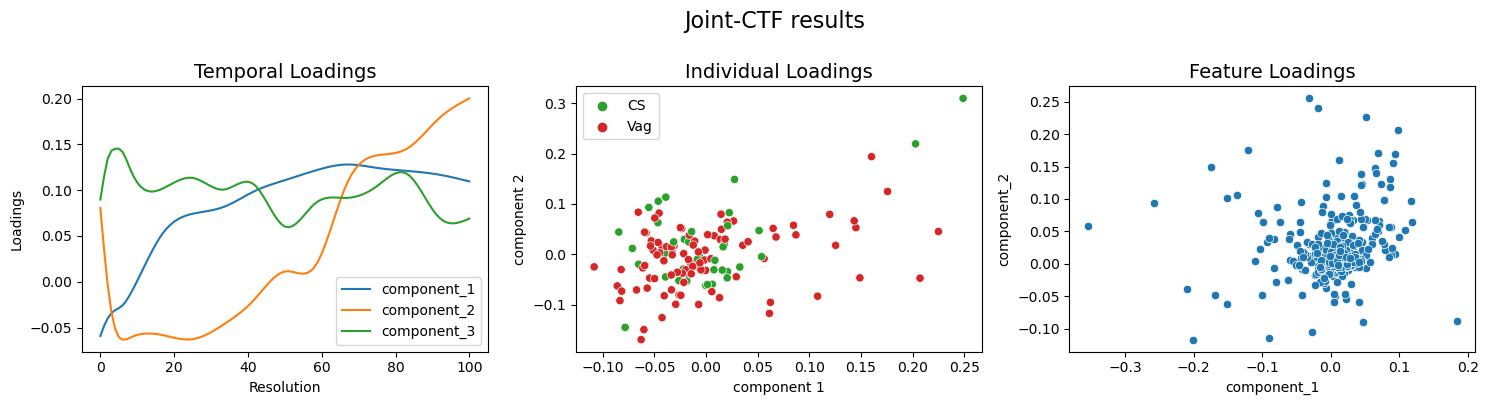

In [ ]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
meta_cat = 'birth_mode_ms'
mf1 = mf.groupby('subjectid_unique').agg({meta_cat:'first'})
group_colors = {'Vag': 'tab:red', 
                'CSseed': 'tab:blue',
                'CS': 'tab:green'}

# Plotting temporal loadings
fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
sns.lineplot(data=state_loads['16S'][['component_1', 'component_2', 'component_3']], 
             ax=axn[0], dashes=False)
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[0].set_xlabel('Resolution')
axn[0].set_ylabel('Loadings')

# Plotting individual loadings
sns.scatterplot(x=subject_loads['16S'][comp1], y=subject_loads['16S'][comp2],  
                ax=axn[1], hue=mf1[meta_cat], palette=group_colors)
axn[1].set_title('Individual Loadings', fontsize=14)
axn[1].legend(loc='best')

# Plotting feature loadings
sns.scatterplot(x=feature_loads['16S'][comp1], y=feature_loads['16S'][comp2], 
                ax=axn[2])
axn[2].set_title('Feature Loadings', fontsize=14)

# Adjusting titles and labels
plt.suptitle('Joint-CTF results', fontsize=16, x=0.52, y=1)
for ax in axn[1:2]:
    ax.set_xlabel(comp1.replace('_', ' '))
    ax.set_ylabel(comp2.replace('_', ' '))

plt.tight_layout()
plt.show()

#REMOVE CSseed

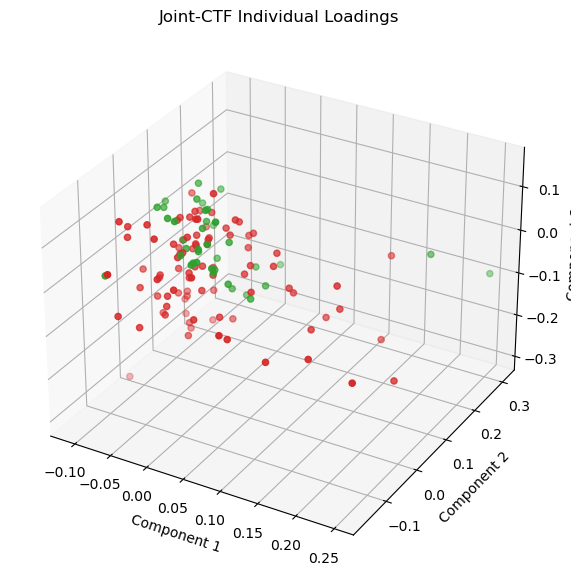

In [ ]:
#plot individual loadings from joint-ctf
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(subject_loads['16S']['component_1'], 
             subject_loads['16S']['component_2'], 
             subject_loads['16S']['component_3'],
             c=mf1[meta_cat].map(group_colors))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('Joint-CTF Individual Loadings')
plt.show()